<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/4-training-models/02_overfitting_and_underfitting_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overfitting and Underfitting Fundamentals

What if your data is more complex than a straight line? 

Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called **Polynomial Regression**.

##Setup

In [12]:
# Common imports
import numpy as np
import numpy.random as rnd
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

##Polynomial Regression

Let’s look at an example. First, let’s generate some nonlinear data, based on a simple quadratic equation (plus some noise).

In [13]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

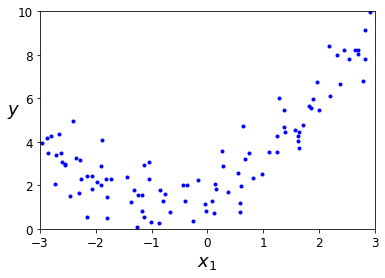

In [14]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Clearly, a straight line will never fit this data properly. 

So let’s use Scikit-Learn’s Poly
nomialFeatures class to transform our training data, adding the square (seconddegree
polynomial) of each feature in the training set as a new feature (in this case
there is just one feature):

In [15]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [16]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of X plus the square of this feature. 

Now you can fit a LinearRegression model to this extended training data:

In [17]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [18]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Let's do prediction.

In [19]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

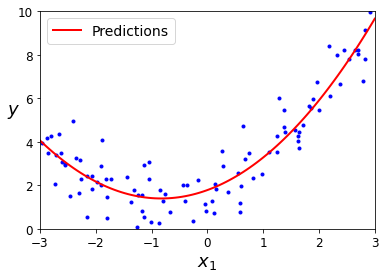

In [20]:
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do).

This is made possible by the fact that PolynomialFeatures also
adds all combinations of features up to the given degree.

For example, if there were two features $a$ and $b$, PolynomialFeatures with `degree=3` would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab, a^2b,$ and $ab^2$.

>`PolynomialFeatures(degree=d)` transforms an array containing $n$
features into an array containing $(n + d)! / d!n!$ features, where $n!$ is
the factorial of $n$, equal to $1 × 2 × 3 × ⋯ × n$. Beware of the combinatorial explosion of the number of features!

##Learning Curves

If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with plain Linear Regression.

For example, We applies
a 300-degree polynomial model to the preceding training data, and compares the
result with a pure linear model and a quadratic model (second-degree polynomial).
Notice how the 300-degree polynomial model wiggles around to get as close as possible
to the training instances.

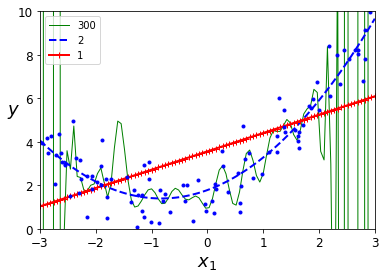

In [22]:
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

This high-degree Polynomial Regression model is severely overfitting the training
data, while the linear model is underfitting it. The model that will generalize best in
this case is the quadratic model, which makes sense because the data was generated
using a quadratic model.


If a model performs well on the training data but generalizes poorly
according to the cross-validation metrics, then your model is overfitting. If it performs
poorly on both, then it is underfitting. This is one way to tell when a model is
too simple or too complex.

In [23]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

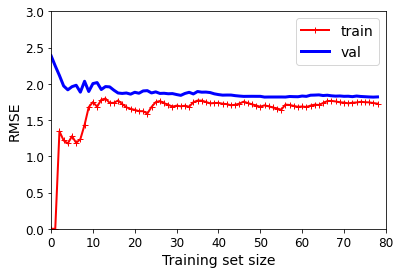

In [24]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show() 

These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.

**If your model is underfitting the training data, adding more training
examples will not help. You need to use a more complex model
or come up with better features.**

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data.

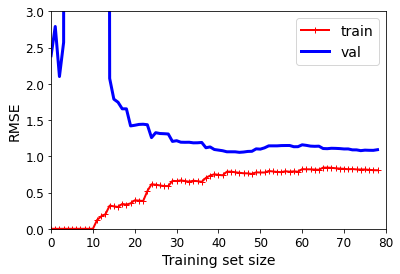

In [25]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show() 

There is a gap between the curves. This means that the model performs significantly
better on the training data than on the validation data, which is the hallmark
of an overfitting model. If you used a much larger training set, however, the
two curves would continue to get closer.

**One way to improve an overfitting model is to feed it more training
data until the validation error reaches the training error.**